In [62]:
import _init_paths
from fast_rcnn.test import test_net
from fast_rcnn.config import cfg, cfg_from_file, cfg_from_list
from datasets.factory import get_imdb
import caffe
import argparse
import pprint
import time, os, sys

import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
%matplotlib inline

## load net

In [7]:
caffe.set_mode_gpu()
caffe.set_device(0)

prototxt = "/home/jguerry/workspace/jg_pfr/models/pascal_voc/VGG16/faster_rcnn_alt_opt/faster_rcnn_test.pt"
caffemodel = "/home/jguerry/workspace/jg_pfr/data/faster_rcnn_models/VGG16_faster_rcnn_final.caffemodel"
net = caffe.Net(prototxt, caffemodel, caffe.TEST)

feat_stride: 16
anchors:
[[ -84.  -40.   99.   55.]
 [-176.  -88.  191.  103.]
 [-360. -184.  375.  199.]
 [ -56.  -56.   71.   71.]
 [-120. -120.  135.  135.]
 [-248. -248.  263.  263.]
 [ -36.  -80.   51.   95.]
 [ -80. -168.   95.  183.]
 [-168. -344.  183.  359.]]


In [20]:
[(k, v.data.shape) for k, v in net.blobs.items()]

[('data', (1, 3, 224, 224)),
 ('im_info', (1, 3)),
 ('conv1_1', (1, 64, 224, 224)),
 ('conv1_2', (1, 64, 224, 224)),
 ('pool1', (1, 64, 112, 112)),
 ('conv2_1', (1, 128, 112, 112)),
 ('conv2_2', (1, 128, 112, 112)),
 ('pool2', (1, 128, 56, 56)),
 ('conv3_1', (1, 256, 56, 56)),
 ('conv3_2', (1, 256, 56, 56)),
 ('conv3_3', (1, 256, 56, 56)),
 ('pool3', (1, 256, 28, 28)),
 ('conv4_1', (1, 512, 28, 28)),
 ('conv4_2', (1, 512, 28, 28)),
 ('conv4_3', (1, 512, 28, 28)),
 ('pool4', (1, 512, 14, 14)),
 ('conv5_1', (1, 512, 14, 14)),
 ('conv5_2', (1, 512, 14, 14)),
 ('conv5_3', (1, 512, 14, 14)),
 ('conv5_3_relu5_3_0_split_0', (1, 512, 14, 14)),
 ('conv5_3_relu5_3_0_split_1', (1, 512, 14, 14)),
 ('rpn/output', (1, 512, 14, 14)),
 ('rpn/output_rpn_relu/3x3_0_split_0', (1, 512, 14, 14)),
 ('rpn/output_rpn_relu/3x3_0_split_1', (1, 512, 14, 14)),
 ('rpn_cls_score', (1, 18, 14, 14)),
 ('rpn_bbox_pred', (1, 36, 14, 14)),
 ('rpn_cls_score_reshape', (1, 2, 126, 14)),
 ('rpn_cls_prob', (1, 2, 126, 14)),


In [21]:
[(k, v[0].data.shape, v[1].data.shape) for k, v in net.params.items()]

[('conv1_1', (64, 3, 3, 3), (64,)),
 ('conv1_2', (64, 64, 3, 3), (64,)),
 ('conv2_1', (128, 64, 3, 3), (128,)),
 ('conv2_2', (128, 128, 3, 3), (128,)),
 ('conv3_1', (256, 128, 3, 3), (256,)),
 ('conv3_2', (256, 256, 3, 3), (256,)),
 ('conv3_3', (256, 256, 3, 3), (256,)),
 ('conv4_1', (512, 256, 3, 3), (512,)),
 ('conv4_2', (512, 512, 3, 3), (512,)),
 ('conv4_3', (512, 512, 3, 3), (512,)),
 ('conv5_1', (512, 512, 3, 3), (512,)),
 ('conv5_2', (512, 512, 3, 3), (512,)),
 ('conv5_3', (512, 512, 3, 3), (512,)),
 ('rpn_conv/3x3', (512, 512, 3, 3), (512,)),
 ('rpn_cls_score', (18, 512, 1, 1), (18,)),
 ('rpn_bbox_pred', (36, 512, 1, 1), (36,)),
 ('fc6', (4096, 25088), (4096,)),
 ('fc7', (4096, 4096), (4096,)),
 ('cls_score', (21, 4096), (21,)),
 ('bbox_pred', (84, 4096), (84,))]

## load image

load the image and show it

In [207]:
# Load the demo image
im_names = ['000456.jpg', '000542.jpg', '001150.jpg',
            '001763.jpg', '004545.jpg', '0000873-000002922482.jpg']

pathToImage = '/home/jguerry/workspace/jg_pfr/data/demo/'+im_names[3]
im = cv2.imread(pathToImage)

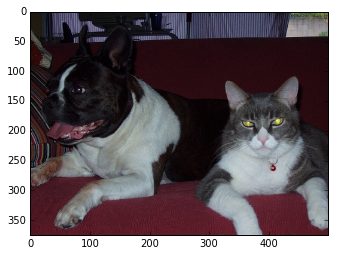

In [208]:
im_rgb = cv2.cvtColor(im, cv2.cv.CV_BGR2RGB)
plt.imshow(im_rgb)

In [209]:
# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))

In [210]:
im2 = transformer.preprocess('data', im)

## Forward image

In [211]:
# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = im2

### perform classification
output = net.forward()

#output_prob = output['prob'][0]  # the output probability vector for the first image in the batch

im_size: (0.0, 0.0)
scale: 0.0
score map size: (1, 9, 14, 14)
reshaping : top_proposal_shape_before = (1, 5)
reshaping : top_proposal_shape_after = (1, 5)


## Show the desired activation map

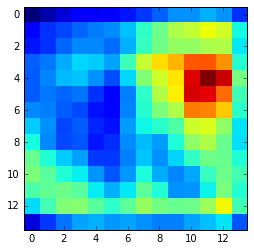

In [212]:
#plt.imshow(net.blobs['rpn/output'].data[0,6,...],interpolation='nearest')
sumrpn = np.sum(net.blobs["rpn/output"].data[0,...],axis=0)
#sumrpn[sumrpn<np.mean(sumrpn)]=0
plt.imshow(sumrpn,interpolation='nearest')

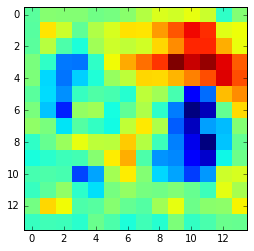

In [213]:
#rpn_cls_score
#conv5_3
sumconv5_3 = np.sum(net.blobs["rpn_cls_score"].data[0,...],axis=0)
#sumconv5_3[sumconv5_3<np.mean(sumconv5_3)]=0
plt.imshow(sumconv5_3,interpolation='nearest')

In [214]:
i = 0

15


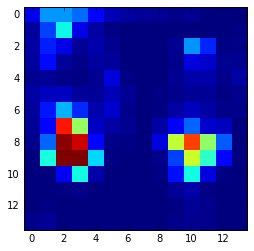

In [249]:
print i
plt.imshow(net.blobs["rpn_cls_prob_reshape"].data[0,i,...],interpolation='nearest')
i = i+1
i = i % 18

In [219]:
net.blobs["rpn_cls_prob_reshape"].data[0,i,...]

array([[ 0.87345994,  0.96678001,  0.97750002,  0.98622757,  0.98767018,
         0.98726451,  0.99213624,  0.99385506,  0.9966324 ,  0.99799323,
         0.99821353,  0.99923098,  0.99923456,  0.99449676],
       [ 0.98755437,  0.99928206,  0.99952102,  0.99904221,  0.99929607,
         0.99953246,  0.99981242,  0.9998821 ,  0.99994993,  0.99997973,
         0.99998331,  0.99999726,  0.99999928,  0.99986303],
       [ 0.9925741 ,  0.99928528,  0.99918145,  0.99722964,  0.99723756,
         0.99567884,  0.99842119,  0.99931514,  0.99985802,  0.99997818,
         0.9999696 ,  0.99997807,  0.99999523,  0.99960417],
       [ 0.99676895,  0.99931526,  0.99881858,  0.98704439,  0.97779024,
         0.99072403,  0.99982494,  0.99998319,  0.99999845,  0.99999976,
         0.99999988,  0.99999928,  0.99999952,  0.99963939],
       [ 0.99467707,  0.99929988,  0.99833196,  0.99017578,  0.9756276 ,
         0.98368257,  0.99965751,  0.999951  ,  0.99999499,  0.99998868,
         0.99999666,  0.99

In [129]:
nb_maps=0
layer_list =list()
layer_list.append('conv5_3')

for idx,item in enumerate(layer_list):
    print(item)
    layer_name = item
    nb_maps = nb_maps + net.blobs[layer_name].data.shape[1]
    
    
print "Total number of map :", nb_maps 
size_grid = int(math.ceil(math.sqrt( nb_map )))
largeur = size_grid
hauteur = size_grid
gs = gridspec.GridSpec(hauteur, largeur)

conv5_3
Total number of map : 512


conv5_3


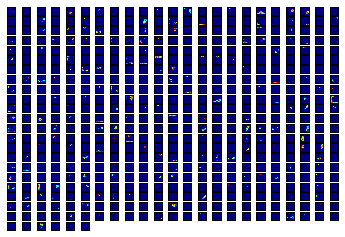

In [130]:
old_nb_map = 0
for idx,item in enumerate(layer_list):
    print(item)
    layer_name = item
    size_map = net.blobs[layer_name].data.shape[2]
    nb_map = net.blobs[layer_name].data.shape[1]
    for i in range(nb_map):
        g = gs[i+old_nb_map]
        ax = plt.subplot(g)
        ax.grid()
        ax.set_xticks([])
        ax.set_yticks([])
        img = net.blobs[layer_name].data[0,i,...]
        #scale = 255. / np.amax(img)
        #img = pytnn.deprocess(img, size_kernel, size_kernel, deepness_kernel, scale).astype(np.uint8)
        #if deepness_kernel==3:
        #    img_to_show = PIL.Image.fromarray(img, 'RGB')
        #elif deepness_kernel==1:
        #    img_to_show = PIL.Image.fromarray(img, 'L')
        #else:
        #    print('problem')

        ax.imshow(img,interpolation='nearest')
    old_nb_map = old_nb_map+nb_map

## Get BB propagation in the layer

## Process correlation between an activation map and bb